In [33]:
import numpy as np
import matplotlib.pyplot as plt
import mod_models as mm
import mod_visualization as mv
import mod_stimulation as ms
from mod_models import logger
import inputools.Trajectory as it
from tqdm import tqdm
from tools.utils import clf

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Settings

In [236]:
N = 2
Nj = 6

#### Inputs

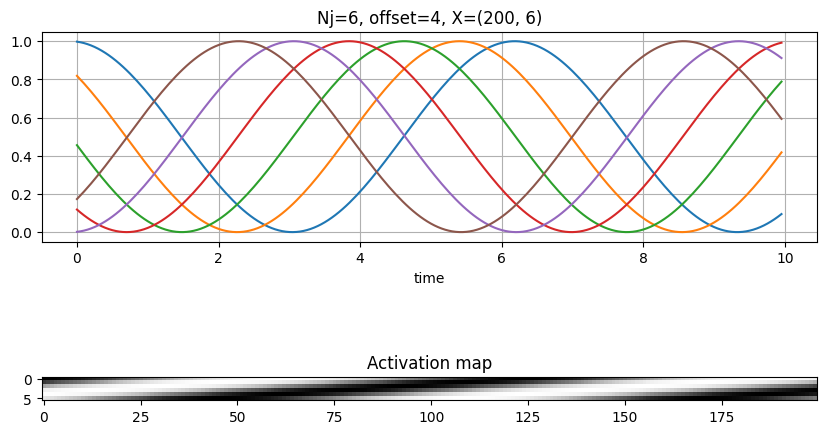

In [194]:
T = 10
dx = 0.05
offset = 4

layer = lambda x: (np.cos(x + np.linspace(1e-1, offset, Nj)) + 1) / 2

Z = np.arange(0, T, dx).reshape(-1, 1)
X = layer(Z)

plt.figure(figsize=(10, 6))

plt.subplot(211)
for x in X.T:
    plt.plot(Z, x)
plt.grid()
plt.title(f"{Nj=}, {offset=}, X={X.shape}") 
plt.xlabel("time")

plt.subplot(212)
plt.title("Activation map")
plt.imshow(X.T, cmap="Greys")
plt.show()


#### Simulation

In [291]:
model = mm.RateNetwork2(N=N, Nj=Nj, 
                       gain=8,
                       bias=4,
                       lr=0.1,
                       rule='oja2',
                       plastic=True,
                       wff_std=0.3,
                       tau_dw=100,
                       is_modulated=True)
logger.info(model)

2023-11-16 21:02:59 | RateNetwork2(N=2, Nj=6, rule=oja2)


In [292]:
model.reset()


record = np.zeros((4, len(X)))
X2 = np.zeros((len(X) + 10, Nj))

for t, x in enumerate(X):
    
    model.step(x=x.reshape(-1, 1))
    record[0, t] = (model.Wff @ x.reshape(-1, 1))[0]
    record[1, t] = (model.Wff @ x.reshape(-1, 1))[1]
    record[2, t] = model.u[0]
    record[3, t] = model.u[1]
    X2[10:t+10] = X[:t]


    clf()
    plt.figure(figsize=(15, 6))
    plt.tight_layout()
    
    plt.subplot(221)
    plt.imshow(X2.T[:, t-10:t], cmap="Greys")
    #plt.ylim((0, 1))
    plt.title(f"{t=}")
    #plt.xlabel("time")
    plt.grid()

    plt.subplot(222)
    plt.axvline(0, color='black', alpha=0.3)
    plt.plot(np.flip(model.Wff[0], axis=0), range(Nj), '-b', alpha=0.4)
    plt.plot(np.flip(model.Wff[0], axis=0), range(Nj), 'ob', alpha=0.4)
    plt.plot(np.flip(model.Wff[1], axis=0), range(Nj), '-r', alpha=0.4)
    plt.plot(np.flip(model.Wff[1], axis=0), range(Nj), 'or', alpha=0.4)
    plt.title(f"Weights")
    plt.yticks(())
    plt.xlim((-1, 7))
    #plt.xlabel("intensity")
    plt.grid()

    plt.subplot(223)
    plt.plot(range(t), record[0, :t])
    plt.plot(range(t), record[1, :t])
    plt.title("Input $W^{ff}$@$x$")
    plt.ylim((0, 20))
    plt.grid()
    
    plt.subplot(224)
    plt.plot(range(t), record[2, :t])
    plt.plot(range(t), record[3, :t])
    plt.title(f"$u$={np.around(model.u.T, 3)} - $m$={np.around(model.m.T, 3)}")
    plt.ylim((0, 1.3))
    plt.grid()
    plt.pause(0.001)

KeyboardInterrupt: 